In [1]:
#modeling data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

file = 'GoodReads_100k_books.csv'
book_data= pd.read_csv(file)

book_rategen = book_data.drop(columns= ['bookformat','img','pages','reviews','isbn','isbn13'])
book_rategen=book_rategen[['title', 'author', 'desc', 'genre', 'rating', 'totalratings', 'link']]
book_rategen=book_rategen.dropna(subset=['title'])
book_rategen.fillna(value='Not Provided', inplace=True)

In [2]:
#preprocessing and data training
book_rategen['genre']=book_rategen['genre'].str.replace('[^a-zA-Z]',' ')
book_rategen['genre']=book_rategen['genre'].str.lower()


#multi-hot encoding genre
book_genre=(book_rategen['genre'].str.split(r',\s*', expand=True)
              .stack()
              .str.get_dummies()
              .groupby(level=0)
              .sum())

print(book_genre.head())

   10th century  11th century  12th century  13th century  14th century  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   15th century  16th century  17th century  1864 shenandoah campaign  \
0             0             0             0                         0   
1             0             0             0                         0   
2             0             0             0                         0   
3             0             0             0                         0   
4             0             0             0                         0   

   18th century  ...  young adult paranormal  young adult romance  \
0             0  ...                     

In [3]:
from sklearn.preprocessing import OneHotEncoder

genre_encoder=OneHotEncoder()
genre_onehot=genre_encoder.fit_transform(book_genre)
genre_onehot_df = pd.DataFrame.sparse.from_spmatrix(genre_onehot)

print(genre_onehot_df.head())

   0     1     2     3     4     5     6     7     8     9     ...  2749  \
0   1.0     0   1.0     0   1.0     0   1.0     0   1.0     0  ...   1.0   
1   1.0     0   1.0     0   1.0     0   1.0     0   1.0     0  ...   1.0   
2   1.0     0   1.0     0   1.0     0   1.0     0   1.0     0  ...   1.0   
3   1.0     0   1.0     0   1.0     0   1.0     0   1.0     0  ...   1.0   
4   1.0     0   1.0     0   1.0     0   1.0     0   1.0     0  ...   1.0   

   2750  2751  2752  2753  2754  2755  2756  2757  2758  
0     0   1.0     0   1.0     0   1.0     0   1.0     0  
1     0   1.0     0   1.0     0   1.0     0   1.0     0  
2     0   1.0     0   1.0     0   1.0     0   1.0     0  
3     0   1.0     0   1.0     0   1.0     0   1.0     0  
4     0   1.0     0   1.0     0   1.0     0   1.0     0  

[5 rows x 2759 columns]


In [4]:
#concat encoder with dataframe
bookplus=pd.concat([book_rategen.drop(columns=['genre']), book_genre], axis=1)

In [5]:
print(bookplus.head())

bookplus_col=bookplus.columns
bookplus_col_df=pd.DataFrame({'rating':[5]})

print(bookplus_col)

                                               title  \
0  Between Two Fires: American Indians in the Civ...   
1                           Fashion Sourcebook 1920s   
2                                         Hungary 56   
3  All-American Anarchist: Joseph A. Labadie and ...   
4                              Les oiseaux gourmands   

                             author  \
0              Laurence M. Hauptman   
1  Charlotte Fiell,Emmanuelle Dirix   
2                     Andy Anderson   
3              Carlotta R. Anderson   
4                     Jean Leveille   

                                                desc  rating  totalratings  \
0  Reveals that several hundred thousand Indians ...    3.52            33   
1  Fashion Sourcebook - 1920s is the first book i...    4.51            41   
2  The seminal history and analysis of the Hungar...    4.15            26   
3  "All-American Anarchist" chronicles the life a...    3.83             6   
4  Aujourdâ€™hui, lâ€™oiseau nous invi

In [6]:
#standardization
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaled_array=scaler.fit_transform(bookplus[['totalratings']])


In [7]:
#Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = bookplus[['rating']]
y = scaled_array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Inspect model parameters
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 0.6840166002587628
R-squared: 0.0005384893174086303
Coefficient: [[0.04284413]]
Intercept: [-0.16190062]


In [9]:
#transformed Target Regressor

from sklearn.compose import TransformedTargetRegressor

model2=TransformedTargetRegressor(LinearRegression(),
                                  transformer=StandardScaler())
model2.fit(bookplus[['rating']],scaled_array)
predictions=model2.predict(bookplus_col_df)
print(predictions)

[[0.04721425]]


In [10]:
#Linear Regression with predictions

X = bookplus[['totalratings']]
y = bookplus['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

if isinstance(X_train, pd.DataFrame) and 'totalratings' in X_train.columns:
    X_train = scaler.fit_transform(X_train['totalratings'].values.reshape(-1, 1))
if isinstance(X_test, pd.DataFrame) and 'totalratings' in X_test.columns:
    X_test = scaler.transform(X_test['totalratings'].values.reshape(-1, 1))

model = LinearRegression()
model.fit(X_train, y_train)

predictions_lin = model.predict(X_test)

print('Predictions ', predictions_lin)

Predictions  [3.83094607 3.83090555 3.83112758 ... 3.83085734 3.83328341 3.83089907]


In [11]:
#Decision tree model with predictions
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
tree_reg = make_pipeline(scaler, DecisionTreeRegressor(random_state=42))
tree_reg.fit(X_train, y_train)

predictionsDT= tree_reg.predict(X_test)

print('Predictions ', predictionsDT)

Predictions  [3.87807018 3.84626866 3.87857143 ... 3.88467085 4.33       3.87509434]


In [12]:
#cross validation

from sklearn.model_selection import cross_val_score

tree_rmses= -cross_val_score(tree_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)


In [13]:
pd.Series(tree_rmses).describe()

count    10.000000
mean      0.400521
std       0.008838
min       0.385709
25%       0.398072
50%       0.401078
75%       0.404243
max       0.415240
dtype: float64

In [14]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

In [15]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
print(X_train.columns)

RangeIndex(start=0, stop=1, step=1)


In [27]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set()

k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    k_scores.append(mse)

optimal_k = k_range[np.argmin(k_scores)]
print(f"Optimal number of neighbors: {optimal_k}")



Optimal number of neighbors: 20


In [28]:
knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=20)

In [29]:
y_pred = knn.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.40
R^2 Score: -0.05


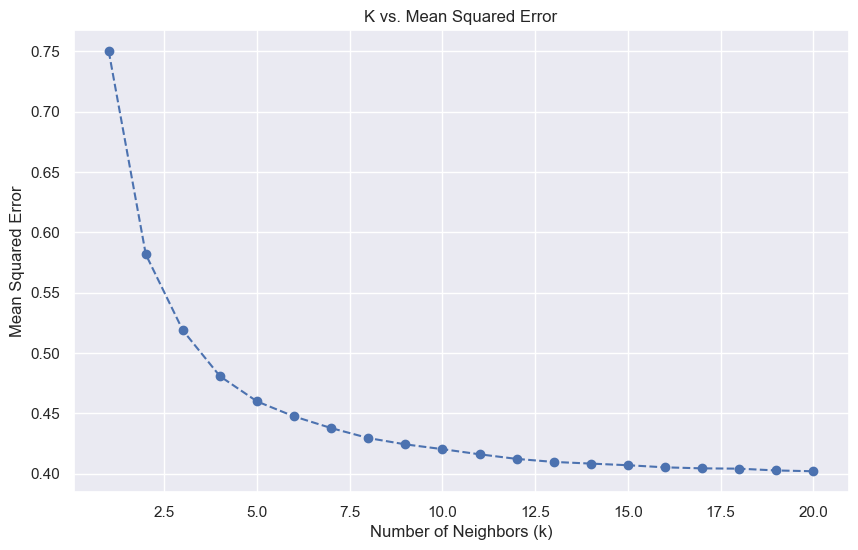

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('K vs. Mean Squared Error')
plt.grid(True)
plt.show()

In [33]:
#KNN predictins and eval
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error

y_pred=knn.predict(X_test_scaled)

# Calculating evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.40
Mean Absolute Error: 0.38
R^2 Score: -0.05


In [ ]:
#choosing the KNN model as it has the better score. Looking to adjust the decisions to better recommend what to read next.